In [1]:
import sys
sys.path.append("..")
from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


94 5 40
📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
        volume.sales        price
count    3256.000000  3256.000000
mean    40150.619340     2.022834
std     56176.374822     0.785525
min       452.360000     0.375449
25%      6606.907500     1.450135
50%     17814.810000     2.002405
75%     53415.565000     2.591298
max    539900.600000     4.036102


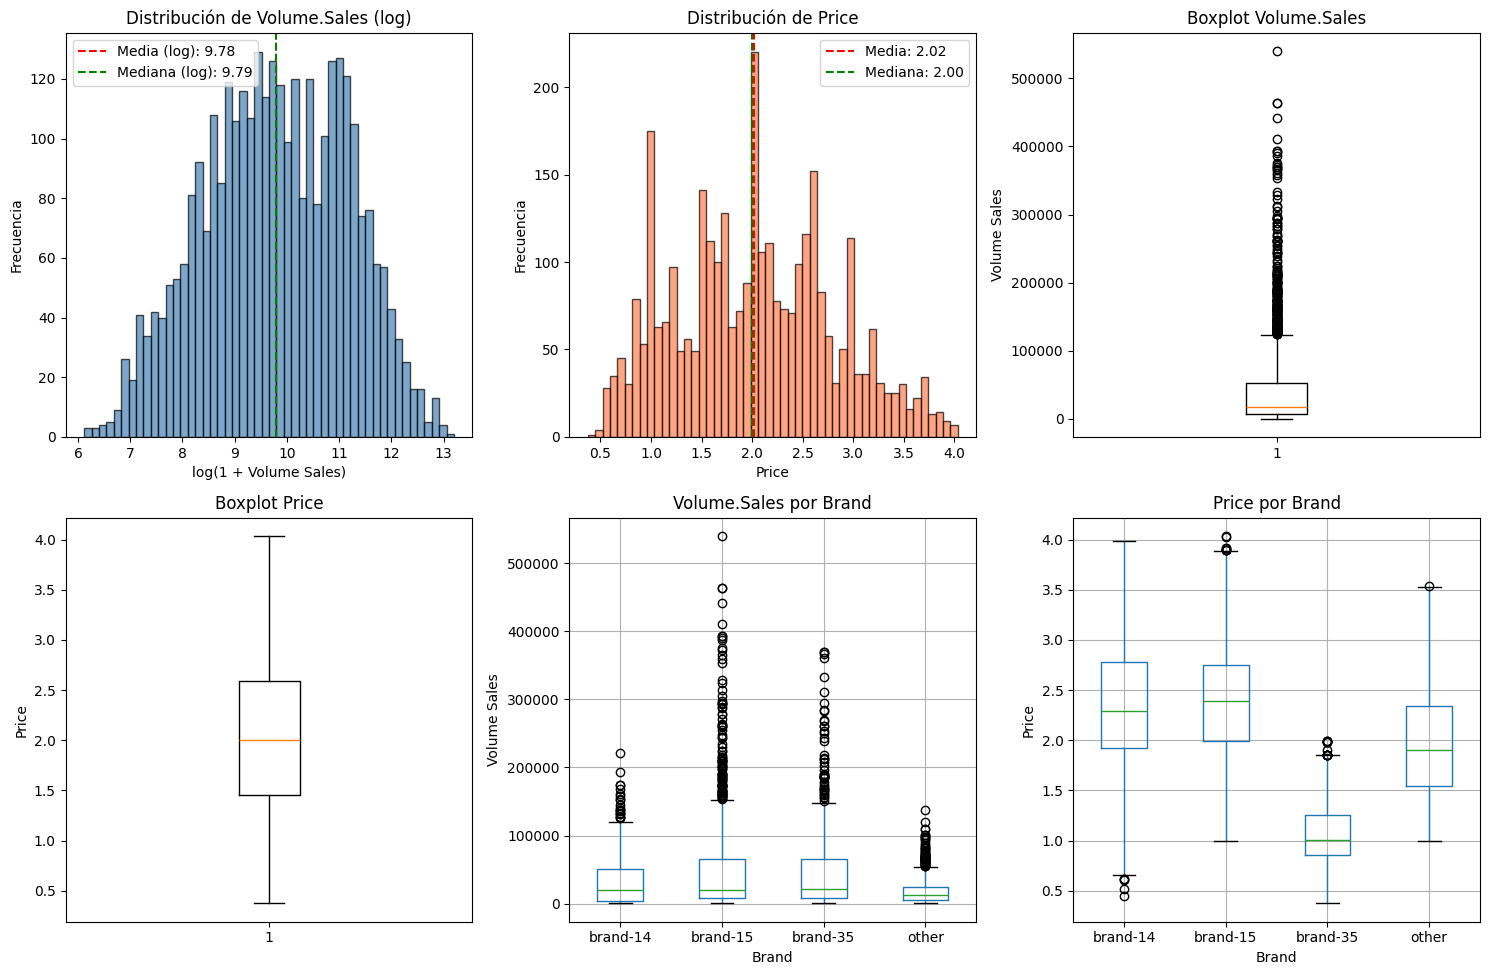


📊 DISTRIBUCIÓN POR CATEGORÍAS


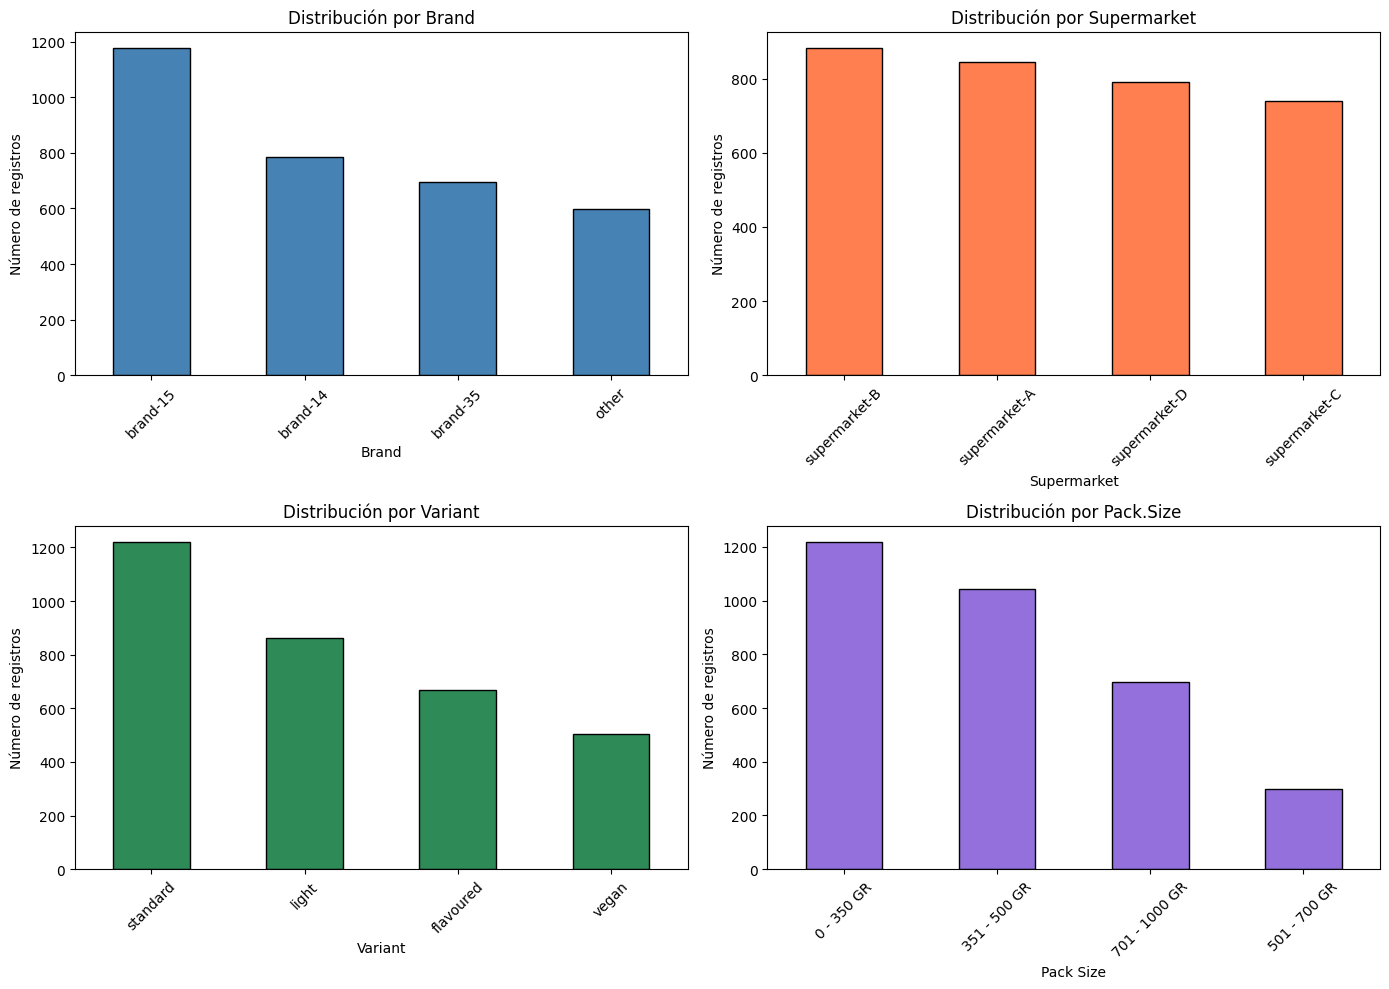


📊 CORRELACIÓN: VOLUME.SALES vs PRICE
Correlación de Pearson: 0.0398


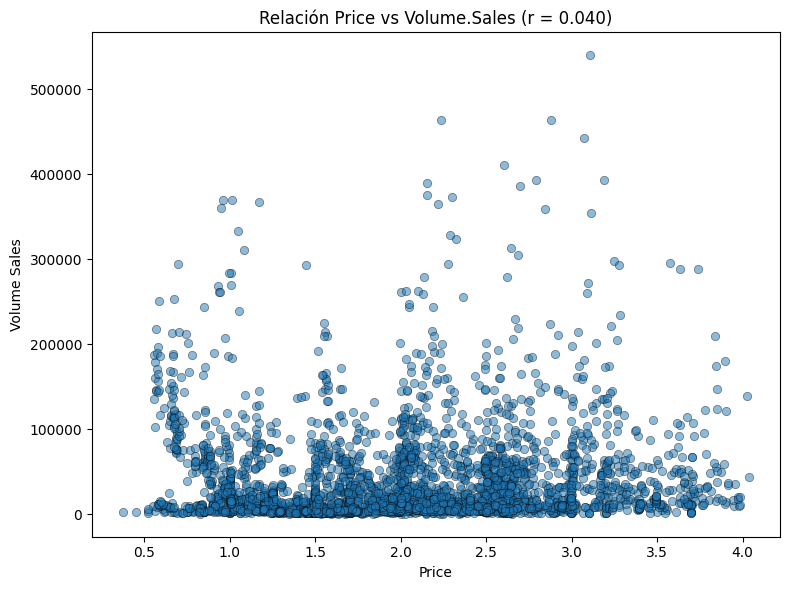

In [2]:
%run 1_preprocessing_data.ipynb
(
    data,
    filter_data, 
    train_data,
    test_data,
    y_train_boxcox,
    y_test_boxcox,
    boxcox_transformation_info,
) = run_preprocessing(ARIMA_model=False)


BUILD DATASET

In [3]:
# ============================================================================
# PASO 2: Construcción del dataset de forecasting
# ============================================================================

# Variables temporales
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Lags del target (por series_id) - CRÍTICO: agrupar por series_id
data['lag_1'] = data.groupby('series_id')['volume.sales'].shift(1)
data['lag_2'] = data.groupby('series_id')['volume.sales'].shift(2)
data['lag_3'] = data.groupby('series_id')['volume.sales'].shift(3)
data['lag_12'] = data.groupby('series_id')['volume.sales'].shift(12)

# Rolling means - CRÍTICO: usar shift(1) antes de rolling para evitar leakage
# Primero hacer shift(1) por grupo, luego aplicar rolling dentro de cada grupo
data['volume_sales_shifted'] = data.groupby('series_id')['volume.sales'].shift(1)
data['rolling_mean_3'] = data.groupby('series_id')['volume_sales_shifted'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
data['rolling_mean_6'] = data.groupby('series_id')['volume_sales_shifted'].rolling(window=6, min_periods=1).mean().reset_index(0, drop=True)
data = data.drop(columns=['volume_sales_shifted'])  # Eliminar columna temporal

# Variables de precio
data['price_lag_1'] = data.groupby('series_id')['price'].shift(1)
data['price_lag_12'] = data.groupby('series_id')['price'].shift(12)

# Renombrar pack.size para consistencia
data['pack_size'] = data['pack.size']

TRANSFORM TARGET AND PREPARATION

In [4]:
# ============================================================================
# PASO 3: Transformación del target y preparación para modelado
# ============================================================================

# Transformar target con log1p
data['target_log'] = np.log1p(data['volume.sales'])

# Seleccionar columnas para el modelo
feature_cols = [
    'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_12',
    'rolling_mean_3', 'rolling_mean_6',
    'price', 'price_lag_1', 'price_lag_12',
    'brand', 'supermarket', 'variant', 'pack_size'
]

categorical_features = ['brand', 'supermarket', 'variant', 'pack_size']

TRAIN_DATA AND TEST_DATA

In [33]:
# data_work = data.copy()

# data_work = data_work.sort_values('date').reset_index(drop=True)

# # Calcular fecha de corte (80% del rango temporal)
# date_min = data_work['date'].min()
# date_max = data_work['date'].max()
# date_range = date_max - date_min
# train_cutoff = date_min + date_range * 0.8

# train_data = data_work[data_work['date'] <= train_cutoff].copy()
# test_data = data_work[data_work['date'] > train_cutoff].copy()

train_cutoff = pd.Timestamp('2023-06-30')
test_start = pd.Timestamp('2023-07-01')
test_end = pd.Timestamp('2023-12-31')

train_data = data[data['date'] <= train_cutoff].copy()
test_data = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()

In [34]:
# ============================================================================
# PASO 5: Manejo de NaNs por lags
# CRÍTICO: Eliminar filas donde lag_12 es NaN antes de entrenar
# ============================================================================

# Eliminar filas con lag_12 NaN (opción simple recomendada)
train_data_clean = train_data.dropna(subset=['lag_12']).copy()
test_data_clean = test_data.dropna(subset=['lag_12']).copy()

print(f"Train después de eliminar NaNs de lag_12: {len(train_data_clean)} filas (se perdieron {len(train_data) - len(train_data_clean)} filas)")
print(f"Test después de eliminar NaNs de lag_12: {len(test_data_clean)} filas (se perdieron {len(test_data) - len(test_data_clean)} filas)")

# Verificar que no haya más NaNs en las features
print(f"\nNaNs en train_data_clean:")
print(train_data_clean[feature_cols].isnull().sum())

# Si hay NaNs en otras features, eliminarlos también
train_data_clean = train_data_clean.dropna(subset=feature_cols + ['target_log'])
test_data_clean = test_data_clean.dropna(subset=feature_cols + ['target_log'])

print(f"\nTrain final: {len(train_data_clean)} filas")
print(f"Test final: {len(test_data_clean)} filas")

Train después de eliminar NaNs de lag_12: 1615 filas (se perdieron 1128 filas)
Test después de eliminar NaNs de lag_12: 513 filas (se perdieron 0 filas)

NaNs en train_data_clean:
month             0
year              0
lag_1             0
lag_2             0
lag_3             0
lag_12            0
rolling_mean_3    0
rolling_mean_6    0
price             0
price_lag_1       0
price_lag_12      0
brand             0
supermarket       0
variant           0
pack_size         0
dtype: int64

Train final: 1615 filas
Test final: 513 filas


In [35]:
# ============================================================================
# PASO 6: Preparar datos para CatBoost
# ============================================================================

# Separar features y target
X_train = train_data_clean[feature_cols].copy()
y_train = train_data_clean['target_log'].copy()

X_test = test_data_clean[feature_cols].copy()
y_test = test_data_clean['target_log'].copy()

# Guardar valores originales para métricas
y_test_original = test_data_clean['volume.sales'].copy()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1615, 15)
X_test shape: (513, 15)


CATBOOST

In [36]:
# ============================================================================
# PASO 7: Entrenamiento del modelo CatBoost
# ============================================================================

# Obtener índices de features categóricas
cat_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in X_train.columns]

model = CatBoostRegressor(
    loss_function='MAE',
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100,
    cat_features=cat_indices
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,
    verbose=100
)

0:	learn: 1.0428682	test: 1.0036529	best: 1.0036529 (0)	total: 2.42ms	remaining: 1.21s
100:	learn: 0.2175868	test: 0.2549483	best: 0.2549483 (100)	total: 197ms	remaining: 779ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2489312503
bestIteration = 140

Shrink model to first 141 iterations.


In [37]:
# PASO 8: Evaluación del modelo

# Predicciones en escala log
y_pred_log = model.predict(X_test)

# Transformar de vuelta a escala original
y_pred = np.expm1(y_pred_log)
y_test_vals = y_test_original.values

# Funciones para calcular métricas
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / (denominator + 1e-9)) * 100

def wape(y_true, y_pred):
    """Weighted Absolute Percentage Error"""
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true))
    return (numerator / (denominator + 1e-9)) * 100

# Calcular métricas
mae = mean_absolute_error(y_test_vals, y_pred)
smape_val = smape(y_test_vals, y_pred)
wape_val = wape(y_test_vals, y_pred)

print("=" * 60)
print("MÉTRICAS EN TEST SET (agregadas)")
print("=" * 60)
print(f"MAE:  {mae:.4f}")
print(f"sMAPE: {smape_val:.4f}%")
print(f"WAPE: {wape_val:.4f}%")
print("=" * 60)


MÉTRICAS EN TEST SET (agregadas)
MAE:  9058.8034
sMAPE: 24.2191%
WAPE: 22.7199%


In [38]:
from sklearn.metrics import r2_score, mean_squared_error

# ============================================================================
# BONDAD DE AJUSTE (TRAIN) vs CAPACIDAD PREDICTIVA (TEST)
# ============================================================================

# Predicciones en TRAIN (bondad de ajuste)
y_train_pred_log = model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = train_data_clean['volume.sales'].values

# Predicciones en TEST (ya calculadas)
# y_pred ya está calculado arriba

# Crear dataframes con resultados
train_results = train_data_clean.copy()
train_results['y_pred'] = y_train_pred
train_results['y_true'] = y_train_original
train_results['dataset'] = 'train'

test_results = test_data_clean.copy()
test_results['y_pred'] = y_pred
test_results['y_true'] = y_test_vals
test_results['dataset'] = 'test'

# Métricas TRAIN (Bondad de Ajuste)
r2_train = r2_score(y_train_original, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred))
mae_train = mean_absolute_error(y_train_original, y_train_pred)
smape_train = smape(y_train_original, y_train_pred)

# Métricas TEST (Capacidad Predictiva)
r2_test = r2_score(y_test_vals, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_vals, y_pred))
mae_test = mean_absolute_error(y_test_vals, y_pred)
smape_test = smape(y_test_vals, y_pred)

print("=" * 70)
print("                    BONDAD DE AJUSTE (TRAIN) vs PREDICCIÓN (TEST)")
print("=" * 70)
print(f"{'Métrica':<12} {'TRAIN (Ajuste)':<20} {'TEST (Predicción)':<20}")
print("-" * 70)
print(f"{'R²':<12} {r2_train:<20.4f} {r2_test:<20.4f}")
print(f"{'RMSE':<12} {rmse_train:<20.4f} {rmse_test:<20.4f}")
print(f"{'MAE':<12} {mae_train:<20.4f} {mae_test:<20.4f}")
print(f"{'sMAPE':<12} {smape_train:<19.2f}% {smape_test:<19.2f}%")
print("=" * 70)

# Interpretar resultados
if r2_train - r2_test > 0.1:
    print("\n⚠️  R² cae significativamente en test - posible overfitting")
elif r2_test > r2_train:
    print("\n✅ El modelo generaliza bien (R² test >= R² train)")
else:
    print("\n✅ Diferencia razonable entre train y test")

                    BONDAD DE AJUSTE (TRAIN) vs PREDICCIÓN (TEST)
Métrica      TRAIN (Ajuste)       TEST (Predicción)   
----------------------------------------------------------------------
R²           0.9476               0.8808              
RMSE         12875.7539           18984.4799          
MAE          6055.2018            9058.8034           
sMAPE        18.76              % 24.22              %

✅ Diferencia razonable entre train y test


In [39]:
# Calcular métricas por cada serie
def metrics_by_series(df):
    return pd.Series({
        'n_obs': len(df),
        'MAE': mean_absolute_error(df['y_true'], df['y_pred']),
        'RMSE': np.sqrt(mean_squared_error(df['y_true'], df['y_pred'])),
        'sMAPE': smape(df['y_true'].values, df['y_pred'].values),
        'R2': r2_score(df['y_true'], df['y_pred']) if len(df) > 1 else np.nan
    })

series_metrics = test_results.groupby('series_id').apply(metrics_by_series).reset_index()
series_metrics = series_metrics.sort_values('MAE', ascending=True)

print("=" * 60)
print("MÉTRICAS POR SERIE (Top 10 mejores MAE)")
print("=" * 60)
print(series_metrics.head(10).to_string(index=False))
print("\n" + "=" * 60)
print("MÉTRICAS POR SERIE (Top 10 peores MAE)")
print("=" * 60)
print(series_metrics.tail(10).to_string(index=False))

# Guardar todas las métricas
series_metrics.to_csv('metrics_by_series.csv', index=False)

MÉTRICAS POR SERIE (Top 10 mejores MAE)
                                  series_id  n_obs        MAE        RMSE     sMAPE        R2
    brand-35_supermarket-B_vegan_0 - 350 GR    6.0 125.062829  168.810073 12.446631  0.308668
       other_supermarket-B_vegan_0 - 350 GR    6.0 132.074901  144.938968 11.486874  0.467820
    brand-35_supermarket-A_vegan_0 - 350 GR    6.0 319.524944  446.273248 16.646417 -0.207381
 brand-15_supermarket-D_standard_0 - 350 GR    6.0 376.372665  447.232752 18.823372 -0.773528
    brand-15_supermarket-A_vegan_0 - 350 GR    6.0 424.464795  545.486984 14.618131 -0.343728
brand-14_supermarket-B_flavoured_0 - 350 GR    6.0 437.905352  510.503692 21.351940 -0.420706
 brand-35_supermarket-C_standard_0 - 350 GR    6.0 531.118819  712.951574 18.483185 -0.432785
    brand-14_supermarket-A_light_0 - 350 GR    6.0 687.892565  908.802235 22.117020  0.332072
    other_supermarket-C_standard_0 - 350 GR    6.0 716.427889  860.502895 11.177533  0.542688
 brand-14_supermarke

In [63]:
# ============================================================================
# SELECCIONAR SERIE PARA VISUALIZAR
# Cambia esta variable y re-ejecuta la celda para ver otra serie
# ============================================================================

# Listar series disponibles
print("Series disponibles:")
available_series = test_results['series_id'].unique()
for i, s in enumerate(available_series[:20]):  # Mostrar primeras 20
    print(f"  {i}: {s}")
if len(available_series) > 20:
    print(f"  ... y {len(available_series) - 20} más")

# SELECCIONA UNA SERIE AQUÍ (copia el nombre exacto o usa el índice)
# SERIE_SELECCIONADA = available_series[0]  # Cambia el índice o pon el nombre
SERIE_SELECCIONADA = 'brand-14_supermarket-A_standard_701 - 1000 GR'   # Cambia el índice o pon el nombre
print(f"\nSerie seleccionada: {SERIE_SELECCIONADA}")

Series disponibles:
  0: brand-14_supermarket-A_flavoured_0 - 350 GR
  1: brand-14_supermarket-A_light_0 - 350 GR
  2: brand-14_supermarket-A_light_501 - 700 GR
  3: brand-14_supermarket-A_light_701 - 1000 GR
  4: brand-14_supermarket-A_standard_0 - 350 GR
  5: brand-14_supermarket-A_standard_501 - 700 GR
  6: brand-14_supermarket-A_standard_701 - 1000 GR
  7: brand-14_supermarket-B_flavoured_0 - 350 GR
  8: brand-14_supermarket-B_light_501 - 700 GR
  9: brand-14_supermarket-B_light_701 - 1000 GR
  10: brand-14_supermarket-B_standard_501 - 700 GR
  11: brand-14_supermarket-B_standard_701 - 1000 GR
  12: brand-14_supermarket-C_light_701 - 1000 GR
  13: brand-14_supermarket-C_standard_701 - 1000 GR
  14: brand-14_supermarket-D_flavoured_0 - 350 GR
  15: brand-14_supermarket-D_light_501 - 700 GR
  16: brand-14_supermarket-D_light_701 - 1000 GR
  17: brand-14_supermarket-D_standard_501 - 700 GR
  18: brand-14_supermarket-D_standard_701 - 1000 GR
  19: brand-15_supermarket-A_flavoured_0 - 3

DIAGNÓSTICO DE FECHAS - Serie: brand-14_supermarket-A_standard_701 - 1000 GR
TRAIN: 18 observaciones
  Primera fecha: 2022-01-31 00:00:00
  Última fecha:  2023-06-30 00:00:00
TEST: 6 observaciones
  Primera fecha: 2023-07-31 00:00:00
  Última fecha:  2023-12-31 00:00:00
GAP entre train y test: 31 días


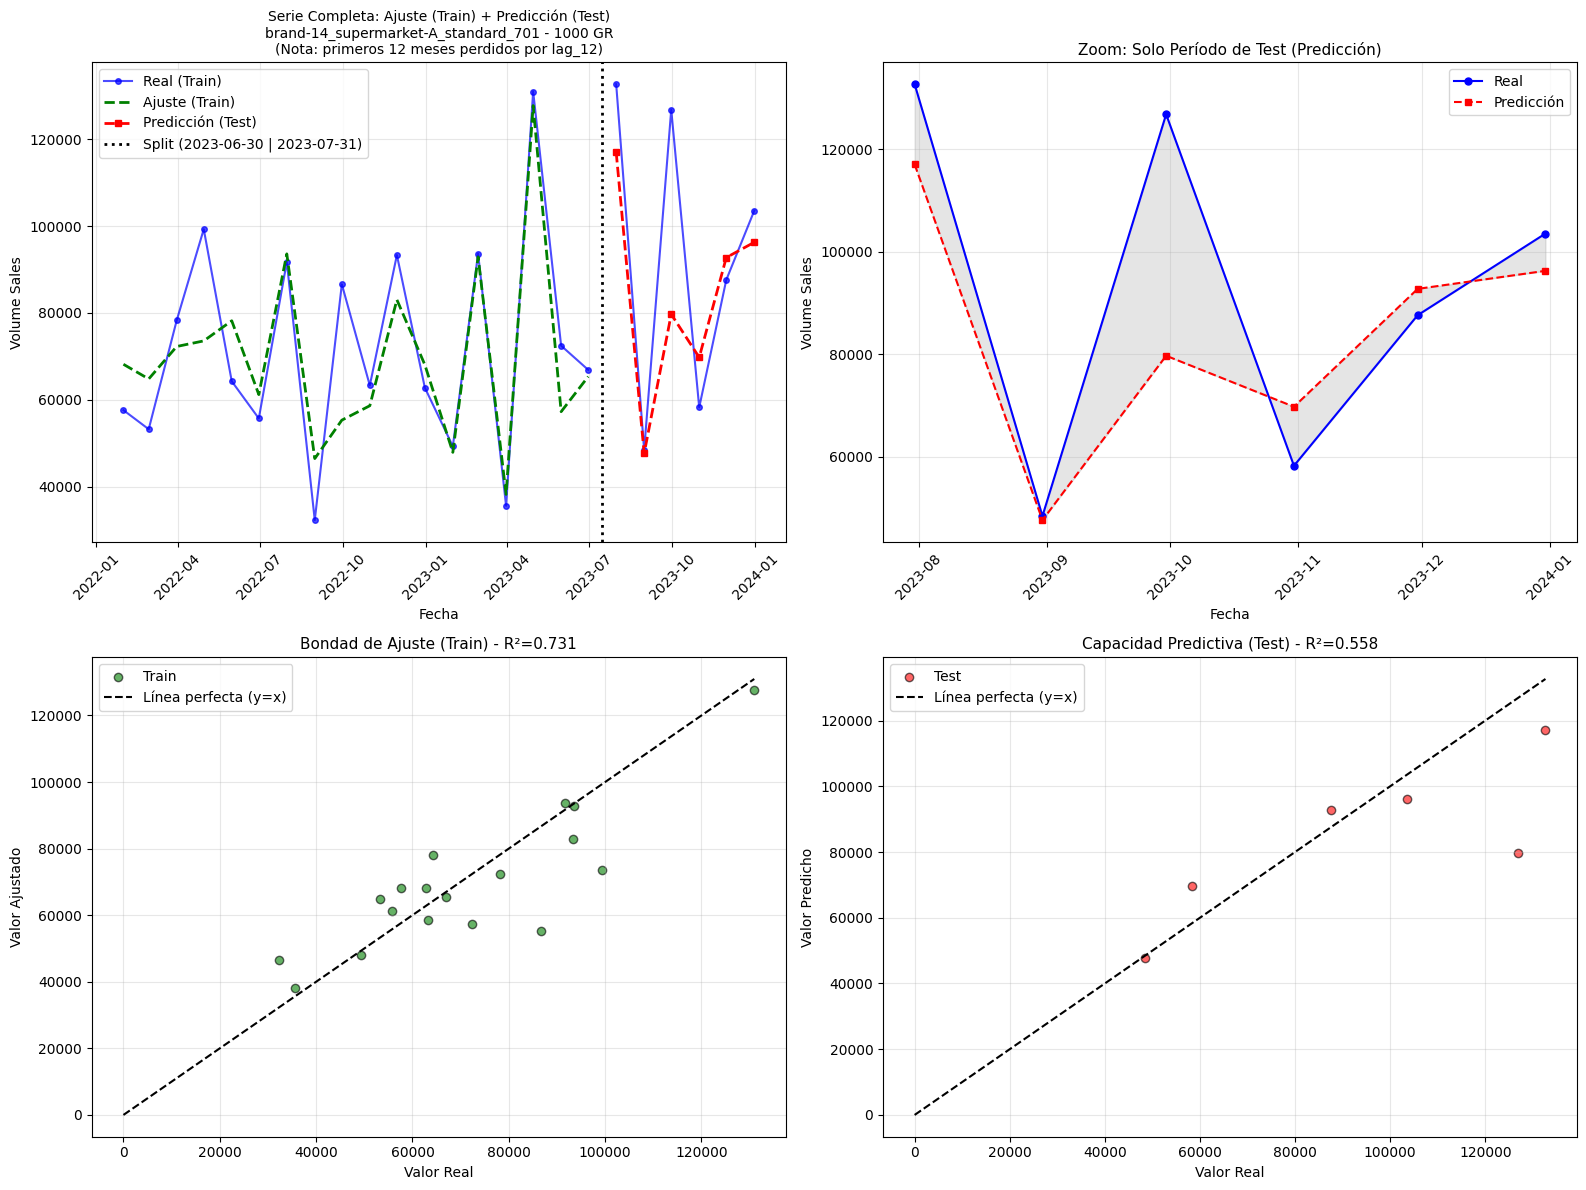

MÉTRICAS SERIE: brand-14_supermarket-A_standard_701 - 1000 GR
Métrica      TRAIN (Ajuste)       TEST (Predicción)   
----------------------------------------------------------------------
Obs.         18                   6                   
R²           0.7315               0.5578              
RMSE         12376.5579           21110.1311          
MAE          9193.9934            14573.7174          
sMAPE        13.97              % 15.13              %


In [64]:
# Filtrar datos de la serie seleccionada (TRAIN + TEST)
serie_train = train_results[train_results['series_id'] == SERIE_SELECCIONADA].copy()
serie_test = test_results[test_results['series_id'] == SERIE_SELECCIONADA].copy()
serie_train = serie_train.sort_values('date')
serie_test = serie_test.sort_values('date')

# Información de fechas para diagnóstico
print("=" * 70)
print(f"DIAGNÓSTICO DE FECHAS - Serie: {SERIE_SELECCIONADA}")
print("=" * 70)
print(f"TRAIN: {len(serie_train)} observaciones")
print(f"  Primera fecha: {serie_train['date'].min()}")
print(f"  Última fecha:  {serie_train['date'].max()}")
print(f"TEST: {len(serie_test)} observaciones")
print(f"  Primera fecha: {serie_test['date'].min()}")
print(f"  Última fecha:  {serie_test['date'].max()}")
if len(serie_train) > 0 and len(serie_test) > 0:
    gap = (serie_test['date'].min() - serie_train['date'].max()).days
    print(f"GAP entre train y test: {gap} días")
print("=" * 70)

# Métricas de la serie en TRAIN (Bondad de Ajuste)
if len(serie_train) > 1:
    serie_r2_train = r2_score(serie_train['y_true'], serie_train['y_pred'])
    serie_rmse_train = np.sqrt(mean_squared_error(serie_train['y_true'], serie_train['y_pred']))
    serie_mae_train = mean_absolute_error(serie_train['y_true'], serie_train['y_pred'])
    serie_smape_train = smape(serie_train['y_true'].values, serie_train['y_pred'].values)
else:
    serie_r2_train = serie_rmse_train = serie_mae_train = serie_smape_train = np.nan

# Métricas de la serie en TEST (Predicción)
if len(serie_test) > 1:
    serie_r2_test = r2_score(serie_test['y_true'], serie_test['y_pred'])
    serie_rmse_test = np.sqrt(mean_squared_error(serie_test['y_true'], serie_test['y_pred']))
    serie_mae_test = mean_absolute_error(serie_test['y_true'], serie_test['y_pred'])
    serie_smape_test = smape(serie_test['y_true'].values, serie_test['y_pred'].values)
else:
    serie_r2_test = serie_rmse_test = serie_mae_test = serie_smape_test = np.nan

# ============================================================================
# GRÁFICO CONJUNTO: TRAIN (Ajuste) + TEST (Predicción)
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Línea temporal COMPLETA (Train + Test)
ax1 = axes[0, 0]
# Train - valores reales y ajustados
ax1.plot(serie_train['date'], serie_train['y_true'], 'b-o', label='Real (Train)', markersize=4, alpha=0.7)
ax1.plot(serie_train['date'], serie_train['y_pred'], 'g--', label='Ajuste (Train)', linewidth=2)
# Test - valores reales y predichos
ax1.plot(serie_test['date'], serie_test['y_true'], 'b-o', markersize=4, alpha=0.7)
ax1.plot(serie_test['date'], serie_test['y_pred'], 'r--s', label='Predicción (Test)', markersize=5, linewidth=2)
# Línea vertical separando train/test
# Línea vertical entre train y test (en el punto medio entre última fecha train y primera fecha test)
if len(serie_train) > 0 and len(serie_test) > 0:
    last_train = pd.to_datetime(serie_train['date'].max())
    first_test = pd.to_datetime(serie_test['date'].min())
    cutoff_date = last_train + (first_test - last_train) / 2
    ax1.axvline(x=cutoff_date, color='black', linestyle=':', linewidth=2, 
                label=f'Split ({last_train.strftime("%Y-%m-%d")} | {first_test.strftime("%Y-%m-%d")})')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Volume Sales')
ax1.set_title(f'Serie Completa: Ajuste (Train) + Predicción (Test)\n{SERIE_SELECCIONADA}\n(Nota: primeros 12 meses perdidos por lag_12)', fontsize=10)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Subplot 2: Solo TEST (zoom en predicciones)
ax2 = axes[0, 1]
ax2.plot(serie_test['date'], serie_test['y_true'], 'b-o', label='Real', markersize=5)
ax2.plot(serie_test['date'], serie_test['y_pred'], 'r--s', label='Predicción', markersize=5)
ax2.fill_between(serie_test['date'], serie_test['y_true'], serie_test['y_pred'], alpha=0.2, color='gray')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Volume Sales')
ax2.set_title('Zoom: Solo Período de Test (Predicción)', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Subplot 3: Scatter TRAIN (Bondad de Ajuste)
ax3 = axes[1, 0]
ax3.scatter(serie_train['y_true'], serie_train['y_pred'], alpha=0.6, c='green', edgecolors='black', label='Train')
if len(serie_train) > 0:
    max_val_train = max(serie_train['y_true'].max(), serie_train['y_pred'].max())
    ax3.plot([0, max_val_train], [0, max_val_train], 'k--', label='Línea perfecta (y=x)')
ax3.set_xlabel('Valor Real')
ax3.set_ylabel('Valor Ajustado')
ax3.set_title(f'Bondad de Ajuste (Train) - R²={serie_r2_train:.3f}', fontsize=11)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Subplot 4: Scatter TEST (Capacidad Predictiva)
ax4 = axes[1, 1]
ax4.scatter(serie_test['y_true'], serie_test['y_pred'], alpha=0.6, c='red', edgecolors='black', label='Test')
if len(serie_test) > 0:
    max_val_test = max(serie_test['y_true'].max(), serie_test['y_pred'].max())
    ax4.plot([0, max_val_test], [0, max_val_test], 'k--', label='Línea perfecta (y=x)')
ax4.set_xlabel('Valor Real')
ax4.set_ylabel('Valor Predicho')
ax4.set_title(f'Capacidad Predictiva (Test) - R²={serie_r2_test:.3f}', fontsize=11)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"../images_markdown/serie_completa_{SERIE_SELECCIONADA.replace(' ', '_')[:30]}.png", dpi=150, bbox_inches='tight')
plt.show()

# Mostrar métricas de la serie (Train vs Test)
print("=" * 70)
print(f"MÉTRICAS SERIE: {SERIE_SELECCIONADA}")
print("=" * 70)
print(f"{'Métrica':<12} {'TRAIN (Ajuste)':<20} {'TEST (Predicción)':<20}")
print("-" * 70)
print(f"{'Obs.':<12} {len(serie_train):<20} {len(serie_test):<20}")
print(f"{'R²':<12} {serie_r2_train:<20.4f} {serie_r2_test:<20.4f}")
print(f"{'RMSE':<12} {serie_rmse_train:<20.4f} {serie_rmse_test:<20.4f}")
print(f"{'MAE':<12} {serie_mae_train:<20.4f} {serie_mae_test:<20.4f}")
print(f"{'sMAPE':<12} {serie_smape_train:<19.2f}% {serie_smape_test:<19.2f}%")
print("=" * 70)

SHAP - Interpretabilidad del Modelo

In [65]:
# Instalar si es necesario: !pip install shap
import shap
shap.initjs()  # Para visualizaciones interactivas en Jupyter

In [66]:
# TreeExplainer está optimizado para modelos basados en árboles (CatBoost, XGBoost, etc.)
explainer = shap.TreeExplainer(model)

# Calcular SHAP values para el conjunto de test
# Nota: puede tardar unos segundos dependiendo del tamaño de X_test
shap_values = explainer.shap_values(X_test)

print(f"Shape de shap_values: {shap_values.shape}")
print(f"Expected value (baseline): {explainer.expected_value:.4f}")

Shape de shap_values: (513, 15)
Expected value (baseline): 9.8087


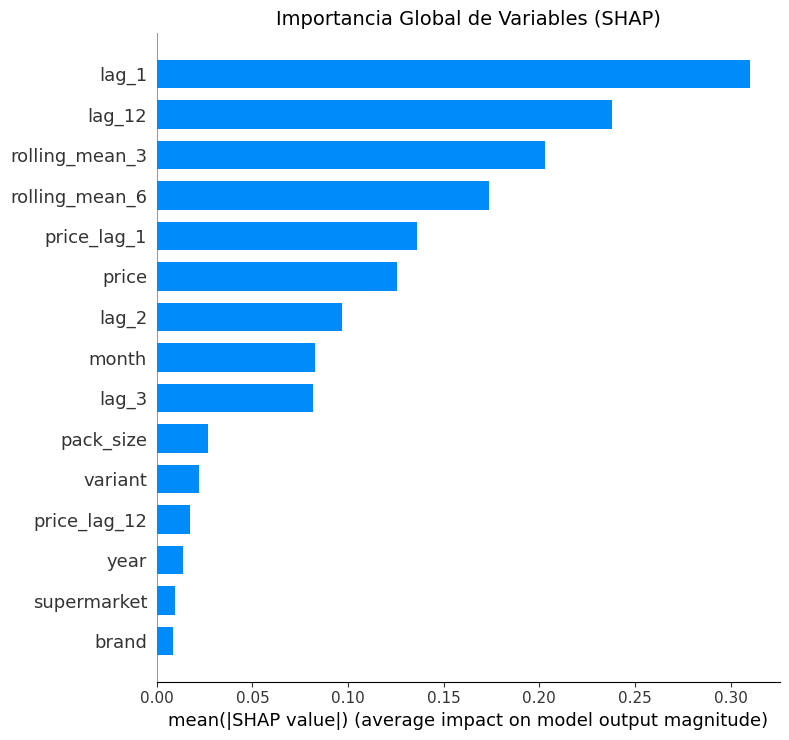

In [67]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Importancia Global de Variables (SHAP)", fontsize=14)
plt.tight_layout()
plt.savefig("../images_markdown/shap_importance_bar.png", dpi=150, bbox_inches='tight')
plt.show()

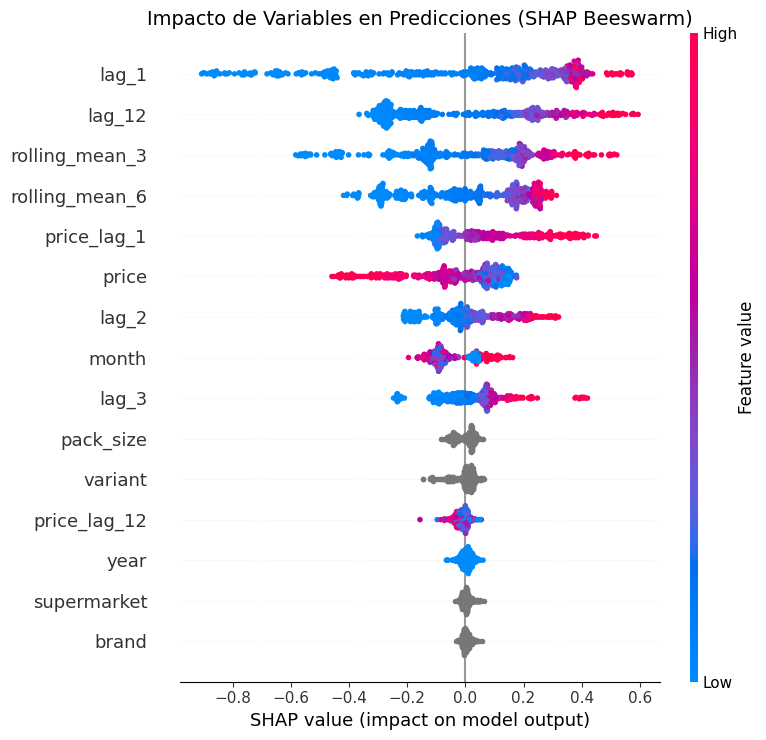

In [68]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Impacto de Variables en Predicciones (SHAP Beeswarm)", fontsize=14)
plt.tight_layout()
plt.savefig("../images_markdown/shap_beeswarm.png", dpi=150, bbox_inches='tight')
plt.show()

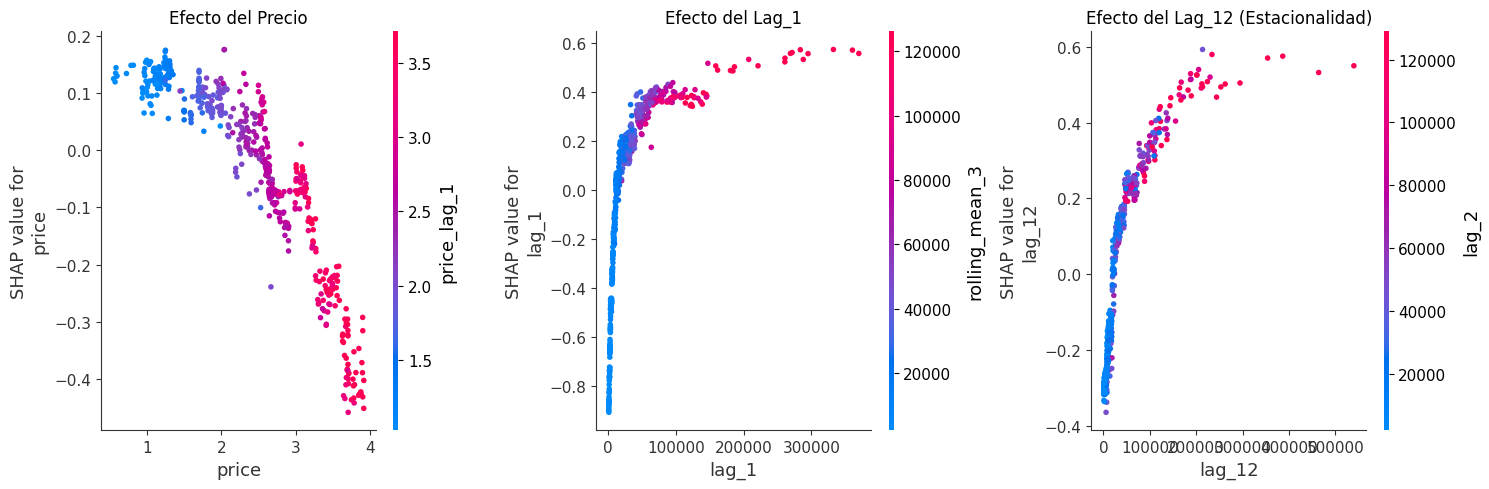

In [69]:
# Dependence plot para PRECIO (variable exógena principal)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Usar ax= para que cada plot se dibuje en su subplot (evita que SHAP cree figuras nuevas)
shap.dependence_plot("price", shap_values, X_test, ax=axes[0], show=False)
axes[0].set_title("Efecto del Precio")

shap.dependence_plot("lag_1", shap_values, X_test, ax=axes[1], show=False)
axes[1].set_title("Efecto del Lag_1")

shap.dependence_plot("lag_12", shap_values, X_test, ax=axes[2], show=False)
axes[2].set_title("Efecto del Lag_12 (Estacionalidad)")

plt.tight_layout()
plt.savefig("../images_markdown/shap_dependence.png", dpi=150, bbox_inches='tight')
plt.show()

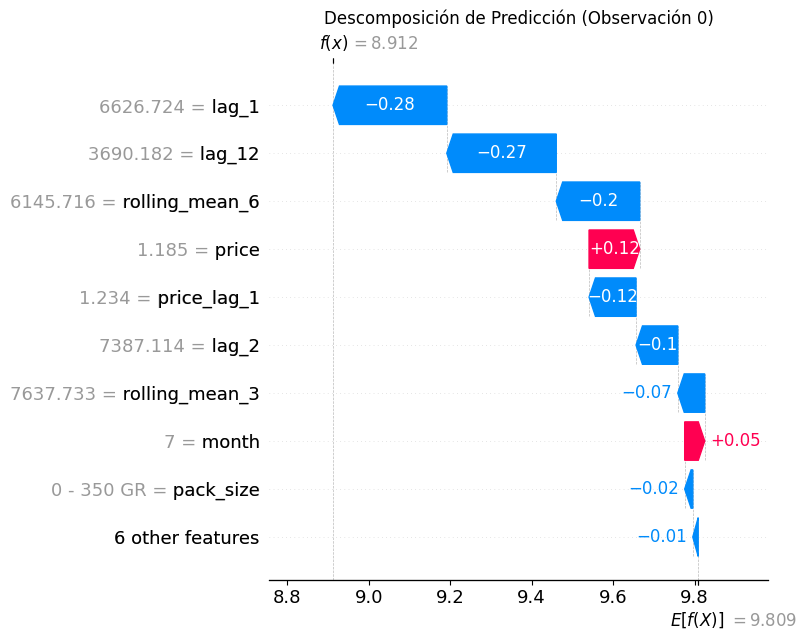

In [70]:
# Seleccionar una observación de ejemplo (ej: la primera del test)
idx = 0

# Crear Explanation object para waterfall
explanation = shap.Explanation(
    values=shap_values[idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[idx],
    feature_names=X_test.columns.tolist()
)

plt.figure(figsize=(12, 6))
shap.plots.waterfall(explanation, show=False)
plt.title(f"Descomposición de Predicción (Observación {idx})", fontsize=12)
plt.tight_layout()
plt.savefig("../images_markdown/shap_waterfall.png", dpi=150, bbox_inches='tight')
plt.show()

In [71]:
# Crear DataFrame con ranking de importancia
importance_df = pd.DataFrame({
    'Variable': X_test.columns,
    'SHAP_Mean_Abs': np.abs(shap_values).mean(axis=0),
    'SHAP_Std': np.abs(shap_values).std(axis=0)
}).sort_values('SHAP_Mean_Abs', ascending=False)

# Añadir porcentaje de importancia
importance_df['Importancia_%'] = (
    importance_df['SHAP_Mean_Abs'] / importance_df['SHAP_Mean_Abs'].sum() * 100
)

print("=" * 60)
print("RANKING DE IMPORTANCIA DE VARIABLES (SHAP)")
print("=" * 60)
print(importance_df.to_string(index=False, float_format="%.4f"))
print("=" * 60)

# Guardar como CSV
importance_df.to_csv('shap_importance.csv', index=False)

RANKING DE IMPORTANCIA DE VARIABLES (SHAP)
      Variable  SHAP_Mean_Abs  SHAP_Std  Importancia_%
         lag_1         0.3103    0.2033        20.0693
        lag_12         0.2379    0.1091        15.3838
rolling_mean_3         0.2028    0.1284        13.1182
rolling_mean_6         0.1738    0.0980        11.2436
   price_lag_1         0.1361    0.1100         8.8030
         price         0.1255    0.1015         8.1178
         lag_2         0.0971    0.0807         6.2779
         month         0.0827    0.0320         5.3464
         lag_3         0.0818    0.0724         5.2889
     pack_size         0.0269    0.0149         1.7383
       variant         0.0221    0.0236         1.4301
  price_lag_12         0.0173    0.0157         1.1177
          year         0.0138    0.0107         0.8912
   supermarket         0.0095    0.0095         0.6150
         brand         0.0086    0.0081         0.5586


In [72]:
# Interaction values (puede ser computacionalmente costoso)
# Descomenta si quieres ver interacciones entre variables
# shap_interaction = explainer.shap_interaction_values(X_test[:100])
# shap.summary_plot(shap_interaction, X_test[:100])

In [73]:
# Mostrar top 5 variables más importantes
print("\n" + "=" * 60)
print("TOP 5 VARIABLES MÁS IMPORTANTES")
print("=" * 60)
for i, row in importance_df.head(5).iterrows():
    print(f"  {row['Variable']}: {row['Importancia_%']:.1f}%")
print("=" * 60)

# Interpretación automática
print("\nINTERPRETACIÓN:")
top_var = importance_df.iloc[0]['Variable']
if 'lag' in str(top_var):
    print(f"  - La variable más importante es {top_var}, indicando alta autocorrelación")
if 'price' in importance_df.head(3)['Variable'].values:
    print("  - El precio es una variable significativa para las predicciones")
if 'month' in importance_df.head(5)['Variable'].values:
    print("  - Existe componente estacional capturado por el mes")


TOP 5 VARIABLES MÁS IMPORTANTES
  lag_1: 20.1%
  lag_12: 15.4%
  rolling_mean_3: 13.1%
  rolling_mean_6: 11.2%
  price_lag_1: 8.8%

INTERPRETACIÓN:
  - La variable más importante es lag_1, indicando alta autocorrelación
